In [1]:
import traceback
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
# seaborn settings, research paper style, and palette
sns.set_context("paper")
sns.set_palette("husl")

In [3]:
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed

def get_latest_event_file(event_dir):
    event_files = os.listdir(event_dir)
    event_files.sort(key=lambda f: os.path.getmtime(os.path.join(event_dir, f)))
    return event_files[-1]

# Extraction function
def tflog2pandas(path):
    runlog_data = pd.DataFrame({"metric": [], "value": [], "smth_value": [], "step": []})
    try:
        event_acc = EventAccumulator(path + "/" + get_latest_event_file(path))
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            smoothed_values = smooth(values, 0.5)
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "smth_value": smoothed_values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data

# Baseline Policy Runs

In [24]:
# load logs
tag_maps_d = {
    "bc_policy_0": "BC",
    "dqn_policy_0": "DQN",
    # "dqn_policy_old_reward_0": "DQN Old Reward",
    "ppo_model_new_reward_policy_0.0": "PPO",
}

tag_maps_s = {
    "bc_policy_stochastic": "BC",
    "dqn_policy_stochastic": "DQN",
    # "dqn_policy_old_reward_stochastic": "DQN Old Reward",
    "ppo_model_new_reward_policy_stochastic": "PPO",
}

tag_maps_e = {
    "bc_policy_0.01": "BC",
    "dqn_policy_0.01": "DQN",
    # "dqn_policy_old_reward_0.01": "DQN Old Reward",
    "ppo_model_new_reward_policy_0.01": "PPO",
}
tag_maps = {
    "deterministic": tag_maps_d,
    "stochastic": tag_maps_s,
    "epsilon": tag_maps_e,
}
dfs = {}
for _main_tag, _tag_map in tag_maps.items():
    holder = list()
    for tag, tag_name in _tag_map.items():
        df = pd.read_csv(f"runs/run_{tag}_log.csv")
        df['tag'] = tag
        df['tag_name'] = tag_name
        holder.append(df)

    df_logs = pd.concat(holder)
    dfs[_main_tag] = df_logs

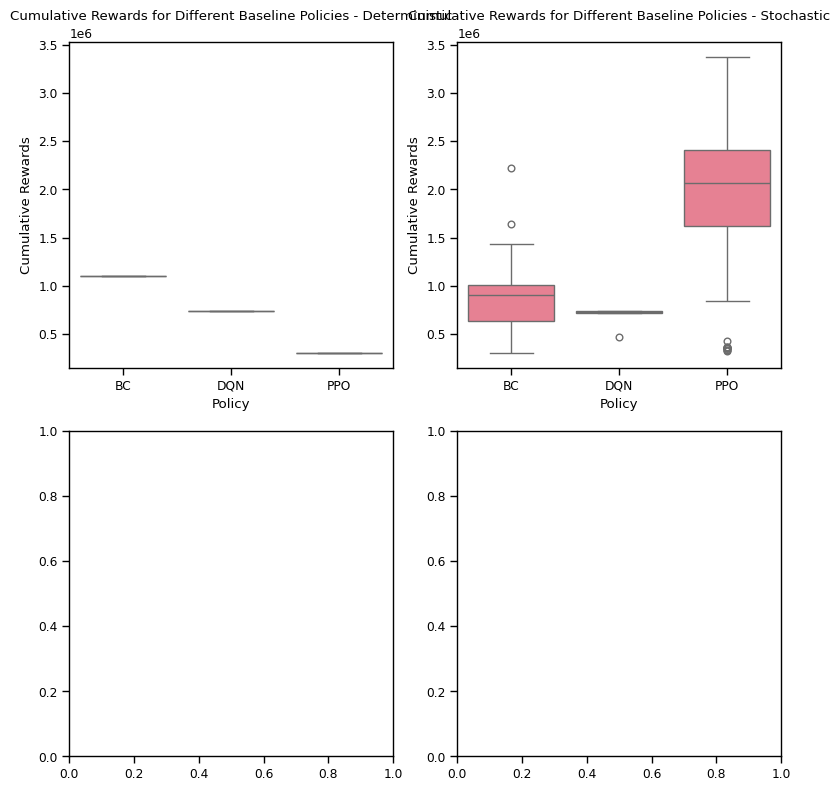

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()

# deterministic
df_logs = dfs["deterministic"]
orders = list(tag_maps['deterministic'].values())
sns.boxplot(data=df_logs, x='tag_name', y='cum_rewards', order=orders, ax=axes[0])
axes[0].set_xlabel("Policy")
axes[0].set_ylabel("Cumulative Rewards")
axes[0].set_title("Cumulative Rewards - Deterministic")

sns.boxplot(data=df_logs, x='tag_name', y='completion', order=orders, ax=axes[2])
axes[2].set_xlabel("Policy")
axes[2].set_ylabel("Level Completion")
axes[2].set_title("Level Completion - Deterministic")

# Set twin y-axis so they are comparable
axes[1].sharey(axes[0])
axes[3].sharey(axes[2])

# stochastic
df_logs = dfs["stochastic"]
orders = list(tag_maps['stochastic'].values())
sns.boxplot(data=df_logs, x='tag_name', y='cum_rewards', order=orders, ax=axes[1])
axes[1].set_xlabel("Policy")
axes[1].set_ylabel("Cumulative Rewards")
axes[1].set_title("Cumulative Rewards - Stochastic")

sns.boxplot(data=df_logs, x='tag_name', y='completion', order=orders, ax=axes[3])
axes[3].set_xlabel("Policy")
axes[3].set_ylabel("Level Completion")
axes[3].set_title("Level Completion - Stochastic")


plt.tight_layout()
# plt.savefig("../project_milestone/figures/cum_rewards_and_completion_baseline.png", dpi=300, bbox_inches='tight')

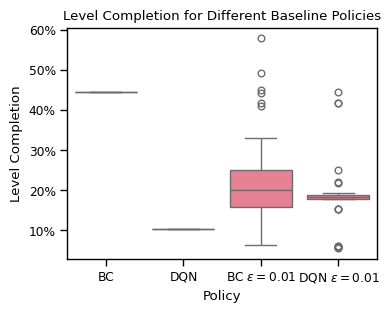

In [ ]:
from matplotlib.ticker import FuncFormatter

orders = list(tag_maps.values())
fig = plt.figure(figsize=(4, 3))
sns.boxplot(data=df_logs, x='tag_name', y='completion', order=orders)
plt.xlabel("Policy")
plt.ylabel("Level Completion")
plt.title("Level Completion for Different Baseline Policies")

# Change y-axis to percentage format
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.savefig("../project_milestone/figures/completions_baseline.png", dpi=300, bbox_inches='tight')

# Loss Functions

In [6]:
experiments = [
    "dqn_experiment_v2",
]

data_holders = []
for exp in experiments:
    path = f"runs/{exp}"
    data = tflog2pandas(path)
    data["exp"] = exp
    data_holders.append(data)

df = pd.concat(data_holders)

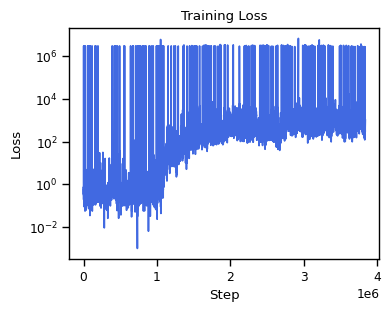

In [30]:
_t = df.loc[df['metric'] == "Loss/train", :]
fig = plt.figure(figsize=(4, 3))
sns.lineplot(data=_t, x='step', y='value',color='royalblue')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Training Loss")
plt.savefig("../project_milestone/figures/dqn_loss.png", dpi=300, bbox_inches='tight')

/tmp/ipykernel_864588/4014983168.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _t['value'] = _t['value'] + 10000


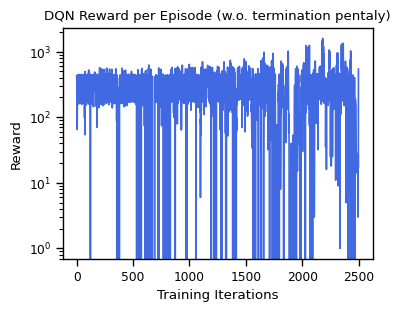

In [31]:
_t = df.loc[df['metric'] == "Reward/episode", :]
_t['value'] = _t['value'] + 10000
fig = plt.figure(figsize=(4, 3))
sns.lineplot(data=_t, x='step', y='value',color='royalblue')
plt.xlabel("Training Iterations")
plt.ylabel("Reward")
plt.yscale("log")
plt.title("DQN Reward per Episode (w.o. termination pentaly)")
plt.savefig("../project_milestone/figures/dqn_rewards.png", dpi=300, bbox_inches='tight')